### Virial stress or contact forces

In [1]:
import os
import matplotlib
import numpy             as     np
import pandas            as     pd
import scipy.optimize    as     opt
import matplotlib.pyplot as     plt
from   matplotlib        import font_manager
from   fractions         import Fraction
import pickle
import warnings
import sys

def updateContForce(theta, binCentersList, forceList, contList, forceVal):
    '''
    This function is used to calulated the complementary contact angle and 
    sum-append the force for that contact to relevant list

    Inputs:
    theta          - primary contact angle. Calculated by arctan2(nz,nx)
    binCentersList - centers of bins
    forceList      - list of total forces for each bin. The force appends here at the relevant bin
    forceVal       - the value of norm of the normal contact force to be sum-appended to 'forceList'
    '''
    
    #bin_Center = int(np.floor(len(binCentersList)/2))
    bin_Center = len(binCentersList) // 2
    bin_Index  = np.argmin(np.abs(binCentersList - theta))
    forceList[bin_Index] += forceVal
    contList[bin_Index]  += 2
    
    if bin_Index != bin_Center:
        bin_Index2 = (bin_Center + 1) + bin_Index if bin_Index < bin_Center else bin_Index - (bin_Center + 1)
        forceList[bin_Index2] += forceVal
        contList[bin_Index2]  += 2

def particleSizeList(randomSeedFile, sizeRatio, npp = 1000):
    '''
    This function reads the random seed file and creates
    a list of particle sizes. The list index is the particle index.

    Inputs:
    randomSeedFile - location for the random seed file. It contains the particle index and sizes
    sizeRatio      - delta or ar for the case
    npp            - system size
    '''

    if sizeRatio == 1:
        # Painting particles randomly in two colours for monodisperse case.
        particleSize = [1]*(int(npp/2)) + [2]*(int(npp/2))
        random.shuffle(particleSize)
    else:
        particleSize = np.loadtxt(randomSeedFile, usecols = 3) # reading only column 3 which has particle size
        randomSeedFile.close()
    return particleSize

def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList
###########################################################
# Matplotlib rc parameters modification

plt.rcParams.update({
  "figure.max_open_warning" : 0,
  "text.usetex"             : True,
  "text.latex.preamble"     : r"\usepackage{amsmath, bm, type1cm}",  # Added \bm for bold math
  "figure.autolayout"       : True,
  "font.family"             : "STIXGeneral",
  "mathtext.fontset"        : "stix",
  "font.size"               : 8,
  "xtick.labelsize"         : 8,
  "ytick.labelsize"         : 8,
  "lines.linewidth"         : 1,
  "lines.markersize"        : 5,
})
#plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'

colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

[7.0, 2.0, 3.0, 1.0] 

[14.0, 7.0, 6.0, 1.0] 

[99.0, 71.0, 27.0, 1.0] 



<Figure size 640x480 with 0 Axes>

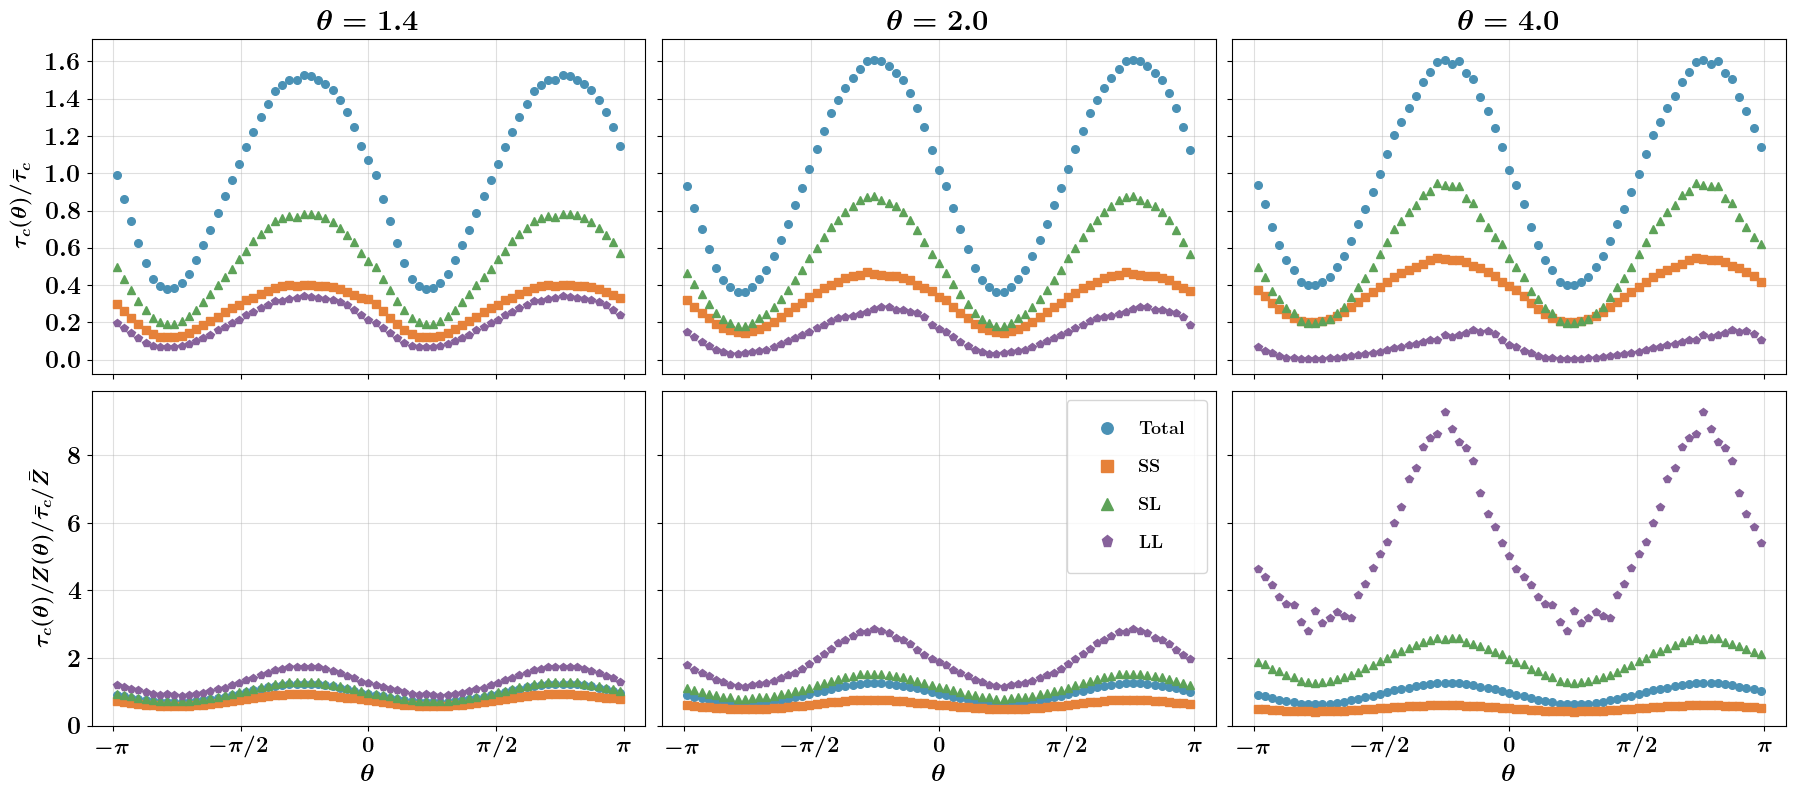

In [2]:
# plot 2 (with normalization)
from matplotlib.ticker import FixedLocator
plt.clf()

topDir        = '/media/rahul/Rahul_2TB/high_bidispersity'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/analysis/figures/angular_plots/angular_virial_stress/'

ranSeedFile = "random_seed.dat"
intFile     = "int_random_seed_params_stress100r_shear.dat"
contFile    = 'contacts.txt'

npp  = 1000 # no. of particles
off  = 100  # steady state cut off
runs = 4
angleBins  = np.linspace(-np.pi, np.pi,72)
binCenters = (angleBins[:-1] + angleBins[1:])/2

phii = 0.75
ar   = [1.4, 2.0, 4.0]

sizePair     = ['Total', 'SS', 'SL', 'LL']
line_markers = ['o', 's', '^', 'p']
colors       = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']
linestyles   = ['None', 'None', 'None', 'None']
plotType     = [r'$\tau_{c}(\theta)/\bar{\tau_{c}}$',r'$\tau_{c}(\theta)/Z(\theta)/\bar{\tau_{c}}/\bar{Z}$']

fig, axs = plt.subplots(len(plotType), len(ar), figsize=(6*len(ar), 4*len(plotType)))

for j, arj in enumerate(ar):
    phir = '{:.3f}'.format(phii) if len(str(phii).split('.')[1])>2 else '{:.2f}'.format(phii)
    if arj == 4.0: phir ='0.78'
    dataname     = topDir + '/NP_' + str(npp) + '/phi_' + phir + '/ar_' + str(arj) + '/Vr_0.5'

    forceBin_Sum = [[0]*len(binCenters) for _ in range(len(sizePair))] # empty nested list for all four runs 
    contList_Sum = [[0]*len(binCenters) for _ in range(len(sizePair))]
    contCount    = [0]*len(sizePair)

    if os.path.exists(dataname):
        for l in range (runs):
            ranFile      = open(f'{dataname}/run_{l+1}/{ranSeedFile}', 'r')
            particleSize = particleSizeList(ranFile, sizeRatio = arj) 
    
            interFile = open(f'{dataname}/run_{l+1}/{intFile}', 'r')
            intList   = interactionsList(interFile) 
           
            for sampleList in intList[off:]:
                for i in range (sampleList.shape[0]):
                    particleSize1 = particleSize[int(sampleList[i,0])]
                    particleSize2 = particleSize[int(sampleList[i,1])]
                    gap           = sampleList[i,5]
                    contState     = int(sampleList[i,10]) # Contact state
                    contForce     = sampleList[i,11] # Norm of normal contact force
                    r             = (gap+2)*(particleSize1 + particleSize2)/2 # center distance of particles
                    virialStress  = r*contForce
                    thetaRad      = np.arctan2(sampleList[i,4], sampleList[i,2])
    
                    if contState == 2:
                        # For all particles.
                        updateContForce(thetaRad, binCenters, forceBin_Sum[0], contList_Sum[0], virialStress)
                        contCount[0] += 2
                        
                        # Small-Small.
                        if (particleSize1 == particleSize2 == 1):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[1], contList_Sum[1], virialStress)
                            contCount[1] += 2
    
                        # Small-Large
                        elif (particleSize1 != particleSize2):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[2], contList_Sum[2], virialStress)
                            contCount[2] += 2
    
                        # Large-Large
                        elif (particleSize1 == particleSize2 > 1):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[3], contList_Sum[3], virialStress)
                            contCount[3] += 2
                            
    forceAvg = np.mean(forceBin_Sum[0])
    contAvg  = np.mean(contList_Sum[0])
    
    print(f'{[np.round(np.sum(a)/np.sum(contList_Sum[3])) for a in contList_Sum]} \n')
    for ii in range(len(forceBin_Sum)):
        forceDensity1 = [i/forceAvg for i in forceBin_Sum[ii]]
        forceDensity2 = [(i/k)/(forceAvg/contAvg) for i,k in zip(forceBin_Sum[ii],contList_Sum[ii])]
        forceDensity1[35] *= 2
        axs[0,j].plot(binCenters, forceDensity1, linestyle=linestyles[ii], 
                marker=line_markers[ii], markersize=5.5, color=colors[ii])
        axs[1,j].plot(binCenters, forceDensity2, linestyle=linestyles[ii], 
                label=fr'\textbf{{{sizePair[ii]}}}',marker=line_markers[ii], 
                      markersize=5.5, color=colors[ii])
        
xticks       = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
xtick_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']
for kk in range(len(plotType)):
    y_mins = [ax.get_ylim()[0] for ax in axs[kk, :]]
    y_maxs = [ax.get_ylim()[1] for ax in axs[kk, :]]
    min_y, max_y = min(y_mins) * 0.98, max(y_maxs) * 1.02
    
    for ax in axs[kk,:]:
        ax.set_ylim(min_y, max_y)
        ax.set_yticks(ax.get_yticks()[(ax.get_yticks() >= min_y) & (ax.get_yticks() <= max_y)])
        #print(min(y_mins), max(y_maxs))
    
    for j, arj in enumerate(ar):
        axs[kk,j].grid(True, alpha=0.4, axis='both', which='both')
        axs[1,j].set_xticks(xticks)
        axs[1,j].set_xticklabels(xtick_labels, fontsize=16)
        axs[0,j].set_xticks(xticks)
        axs[0,j].set_xticklabels([])
        axs[1,j].set_xlabel(r'$\theta$', fontsize=18)
        axs[0,j].set_title(fr'$\theta = {arj}$', fontsize=21)
        if j == 0:
            axs[kk,j].tick_params(axis='y', labelsize=18)
            axs[kk,j].set_ylabel(plotType[kk], fontsize=16, labelpad=10)
        else:
            axs[kk,j].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
        
axs[1, 1].legend(loc='best', fontsize=13, labelspacing=1.2,borderpad=1.2, markerscale=1.5)

plt.tight_layout()
if True:
    figFormat     = ".svg"
    plt.savefig(fig_save_path + '/angularVirialStressAllSizePair_both2_NP_' + str(npp) + figFormat, bbox_inches = "tight", dpi = 500)

plt.show()